In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

    
from types import ModuleType
from typing import Sequence, Tuple
import gymnasium as gym
# import gym

from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import torch
import torch.nn as nn

from EpisodeDataset import EpisodeDataset, ProcgenEpisodeDataset

import torch
from torch.utils.data import DataLoader


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
  import matplotlib.pyplot as plt
import torch
import numpy as np

from typing import List

import visual_gridworld
from visual_gridworld.gridworld.minigrid_procgen import GridworldResizeObservation # absolute import


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit import script
from torch import Tensor
from typing import List, Literal, Optional, Sequence, Tuple, Union
from functools import partial


class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x


@script
def gaussian_fn(M: int, std: int) -> Tensor:
    n = torch.arange(0, M) - (M - 1.0) / 2.0
    sig2 = 2 * std * std
    w = torch.exp(-n ** 2 / sig2)
    return w

@script
def gkern(kernlen: int = 256, std: int = 128, vmin: float = 0, vmax: float = 1) -> Tensor:
    """Returns a 2D Gaussian kernel array."""
    gkern1d = gaussian_fn(kernlen, std=std) 
    gkern2d = torch.outer(gkern1d, gkern1d)
    return gkern2d * (vmax - vmin) + vmin


class Template(nn.Module):
    def __init__(self, M: int, out_size: int, var: torch.IntTensor, stride: int = 1,
                 cutoff: float = 0.2, initial_mixin_factor: float = 0.0,
                 device: torch.device = None):
        super().__init__()
        # Initialize basic parameters
        self.out_size = out_size  # Template size
        self.channels = M  # Number of channels

        # Mixin factor controls the interpolation between identity and templates
        self._mixin_factor = initial_mixin_factor
        self.cutoff = cutoff  # Cutoff threshold for template values
        self.device = device  # Device to run the model on (CPU/GPU)
        self.var = var  # Variance, can be a range or a fixed value
        self.stride = stride # Distance between mean of filters
        # Initially create templates based on the current variance
        self.create_new_templates(self._curr_var())

    @torch.jit.export
    def _curr_var(self, mixin: Optional[float] = None) -> int:
        # Determine the current variance based on the mixin factor
        # If `var` is a fixed int, just return it. If it's a tuple, interpolate.
        if mixin is None:
            return int(self.var[0] + self._mixin_factor * (self.var[1] - self.var[0]))
        return int(self.var[0] + mixin * (self.var[1] - self.var[0]))
    
    @torch.jit.export
    def set_mixin_factor(self, mixin_factor: float) -> None:
        # self.cutoff = max(0., min(1., mixin_factor))
        # # Update the mixin factor, ensuring it remains between 0 and 1
        _mixin_factor = max(0., min(1., mixin_factor))
        
        # If `var` is not a fixed value, recreate templates with the new variance
        if self._mixin_factor != _mixin_factor:
            self.create_new_templates(self._curr_var(_mixin_factor))
        self._mixin_factor = float(_mixin_factor)
        
    def create_new_templates(self, var: int) -> None:
        # Method to generate new templates based on given variance `var`
        
        n_square = (self.out_size * self.out_size)  # Total number of pixels
        tau = 0.5 / n_square  # Scaling factor for templates
        self.tau = tau
        alpha = n_square / (1 + n_square)  # Weight for positive template contribution
        beta = 4  # Scaling factor to amplify template values
        
        # Generate a base mask with Gaussian blur, cutoff, and scaling
        base = gkern(self.out_size*2-1, var, vmin=-self.cutoff, vmax=1.)[:,:,None]
        base = F.relu(base) * 2 - 1
        base = tau * torch.clamp(beta * base / self.out_size, min=-1)

        # Extract patches from the base mask to create templates
        templates = base.unfold(0, self.out_size, self.stride) \
                        .unfold(1, self.out_size, self.stride) \
                        .reshape(-1, self.out_size, self.out_size)
        templates = torch.flip(templates, dims=(0,))  # Correct orientation
        
        # Transfer templates to the specified device
        self.templates_f = templates.requires_grad_(False).to(self.device)
        neg_template = -tau * torch.ones(1, self.out_size, self.out_size)
        templates = torch.cat([templates, neg_template], 0)
        self.templates_b = templates.requires_grad_(False).to(self.device)

        if not hasattr(self, 'p_T'):
        # Probability distribution over templates
            p_T = [alpha / n_square for _ in range(self.templates_f.shape[0])]
            p_T.append(1 - alpha)  # Add probability for the negative template
            self.p_T = torch.FloatTensor(p_T).requires_grad_(False).to(self.device)
        
    def get_mask_from_indices(self, indices: Tensor) -> Tensor:
        # Select templates for each index found by max pooling
        selected_templates = torch.stack([self.templates_f[(i/(self.stride**2)).long()] for i in indices], dim=0)
        # Apply the selected templates to the input and return the masked input and the templates
        mask = (selected_templates / selected_templates.max())
        mask = F.relu(mask - self.cutoff) / self.cutoff
        return mask        

    def get_masked_output(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        # For each element in the batch, find the max pool index to select the corresponding template
        _, indices = F.max_pool2d(x, self.out_size, return_indices=True)
        indices = indices.view(x.shape[:2]).long()
        
        # Interpolate between the identity mask and the filtered templates based on mixin_factor
        mask = self.get_mask_from_indices(indices)
        # templates = torch.lerp(self.identity_mask, self.templates_f, self._mixin_factor)
        x_masked = x * mask
        return x_masked, mask
    
    def compute_local_loss(self, x: Tensor) -> Tensor:  
        # Calculate the tensor dot product between input x and templates, then softmax to get probabilities
        tr_x_T = torch.einsum('bcwh,twh->cbt', x * self.tau, self.templates_b)
        p_x_T = F.softmax(tr_x_T, dim=1)
        # Calculate the adjusted probability distribution of x given T
        p_x = torch.einsum('t,cbt->cb', self.p_T, p_x_T)
        p_x = torch.log(p_x_T/p_x[:, :, None])
        # Calculate the log probability loss
        p_x_T_log = torch.einsum('cbt,cbt->ct', p_x_T, p_x)
        # Negative log likelihood loss
        loss = -torch.einsum('t,ct->c', self.p_T, p_x_T_log)
        return loss

    def forward(self, x: Tensor, train: bool = True) -> Union[Tuple[Tensor, Tensor, Tensor], Tuple[Tensor, Tensor]]:
        # Main forward pass
        x, obs_mask = self.get_masked_output(x)  # Get masked output based on the current mixin_factor
        if train:
            # If training, also compute the local loss
            loss_1 = self.compute_local_loss(x)
            return x, obs_mask, loss_1  # Return the masked input and the computed loss
        return x, obs_mask # For inference, just return the masked input

class SiameseAttentionNetwork(nn.Module):
    def __init__(self, base_network, attention_hidden_size=128, num_classes=10):
        super(SiameseAttentionNetwork, self).__init__()
        self.base_network = base_network
        self.mask = False
        # Attention mechanism
        self.attention_fc = nn.Sequential(
            nn.LazyLinear(attention_hidden_size),
            nn.ReLU(),
            nn.Linear(attention_hidden_size, 1)
        )


        self.template_counts = attention_hidden_size
        self.template = torch.jit.script(Template(M=1, cutoff=0.2, out_size=21, var=[6,5], stride=4, device=device))
        
        
        # Spatial attention module
        self.spatial_attention_conv = nn.Conv2d(1, 1, kernel_size=3, padding=1)
        
        # Classifier
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x1, x2):
        # Forward pass through base network
        out1 = self.base_network(x1)
        out2 = self.base_network(x2)
        
        # Compute attention weights
        att1 = self.attention_fc(out1.reshape(out1.size(0), -1))
        att2 = self.attention_fc(out2.reshape(out2.size(0), -1))
        att1 = F.softmax(att1, dim=1).unsqueeze(2).unsqueeze(3)
        att2 = F.softmax(att2, dim=1).unsqueeze(2).unsqueeze(3)

        if self.mask:
            out1, obs_mask, local_loss = self.template(out1.sum(dim=1)[:,None], train=True)
            out2, obs_mask, local_loss = self.template(out2.sum(dim=1)[:,None], train=True)

        
        # Apply spatial attention
        out1 = out1 * att1
        out2 = out2 * att2
        
        # Merge features
        merged_features = torch.cat((out1, out2), dim=1)
        
        # Classifier
        out = F.relu(self.fc1(merged_features.reshape(merged_features.size(0), -1)))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out, att1, att2

# Example usage:
# Create the base network
base_network = BaseNetwork()

# Create the Siamese network
siamese_net = SiameseAttentionNetwork(base_network)

# Test forward pass
x1 = torch.randn(1, 3, 84, 84)
x2 = torch.randn(1, 3, 84, 84)
output, att1, att2 = siamese_net(x1, x2)
print("Output shape:", output.shape)
print("Attention weights for x1:", att1.shape)
print("Attention weights for x2:", att2.shape)


Output shape: torch.Size([1, 10])
Attention weights for x1: torch.Size([1, 1, 1, 1])
Attention weights for x2: torch.Size([1, 1, 1, 1])


In [9]:
from functools import reduce
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

class SpatialTransformer(nn.Module):
    def __init__(self):
        super(SpatialTransformer, self).__init__()
        
        self.localization = nn.Sequential(
            nn.LazyConv2d(8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        self.fc_loc = nn.Sequential(
            nn.LazyLinear(32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        self.fc_loc[2].weight.data.fill_(0)
        self.fc_loc[2].bias.data = torch.FloatTensor([16, 0, 0, 0, 16, 0])
        
        self.e = None

    def forward(self, x):
        if self.e is None:
            s = x.shape[-1]
            o = 1. - 0.9*(torch.linspace(-s // 2, s // 2, s).abs() / float(s//2))
            self.e = torch.outer(o, o)
        B = x.shape[0]
        x = x * self.e
        theta = self.localization(x)
        theta = theta.reshape(B, -1)
        theta = self.fc_loc(theta)
        theta = theta.view(-1, 2, 3)
        
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        # Calculate central position of the transformation
        central_pos = theta[...,2]  # Calculate mean along spatial dimensions
        
        # Calculate scaling factor to encourage larger transformed images
        scale_factor = torch.mean(torch.abs(theta[:, :, :2]))  # Calculate mean of scaling factors
        
        return x, central_pos, scale_factor

class _ActionPredictor(nn.Module):
    def __init__(self):
        super(_ActionPredictor, self).__init__()
        
        self.conv1 = nn.Conv2d(2*3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.LazyLinear(512)
        self.fc2 = nn.Linear(512, 4)  # Assuming 3 actions
        
    def forward(self, x):
        B = x.shape[0]
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(B, -1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

class ImageActionPredictor(nn.Module):
    def __init__(self):
        super(ImageActionPredictor, self).__init__()
        
        self.spatial_transformer = SpatialTransformer()
        self.action_predictor = _ActionPredictor()
        
    def forward(self, x1, x2):
        # Transform x1 and x2 using Spatial Transformer
        x1_transformed, pos1, scale_factor1 = self.spatial_transformer(x1)
        x2_transformed , pos2, scale_factor2 = self.spatial_transformer(x2)
        
        # Concatenate the transformed images
        x = torch.cat((x1_transformed, x2_transformed), dim=1)
        
        # Predict actions
        actions = self.action_predictor(x)
        
        return actions, [pos1, pos2], scale_factor1+scale_factor2

# # Example usage
# # Assuming x1 and x2 are torch tensors of shape (batch_size, channels, height, width)
# x1 = torch.randn(10, 3, 8, 8)
# x2 = torch.randn(10, 3, 8, 8)

# model = ImageActionPredictor()
# actions = model(x1, x2)
# print(actions)


In [10]:

from scratchpads.EpisodeDataset import GridworldEpisodeDataset, MultiEpisodeDataset



class LimitActions(gym.ActionWrapper):
    def __init__(self, env: gym.Env, actions: List[int]):
        assert isinstance(env.action_space, gym.spaces.Discrete) or isinstance(env.single_action_space, gym.spaces.Discrete)

        super().__init__(env)
        if hasattr(env, 'single_action_space'):
            self.single_action_space = gym.spaces.Discrete(len(actions))
            if len(env.action_space.shape) > 1:
                self.action_space = gym.spaces.MultiDiscrete((env.action_space.shape[0], ) * len(actions))
            else:
                self.action_space = gym.spaces.MultiDiscrete((len(actions), ))
        else:
            self.action_space = gym.spaces.Discrete(len(actions))

        self.action_indices = np.array(actions)

    def action(self, action):
        return self.action_indices[np.array(action)]
    
env_fn = lambda: LimitActions(GridworldResizeObservation(gym.make("Visual/MultiRoomS10N6-Gridworld-v0"), (84, 84)), [0, 1, 2, 3])
# train_data = ProcgenEpisodeDataset('procgen-coinrun-v0', wrapper=lambda x:  gym.wrappers.ResizeObservation(gym.wrappers.GrayScaleObservation(x), shape=(84,84)),
#             num_envs=1, max_steps=100, episodes_per_epoch=100, skip_first=10, repeat_action=1, device='cpu') 
train_data = GridworldEpisodeDataset(env_fn, max_steps=200, episodes_per_epoch=50, skip_first=0, repeat_action=1, device=device)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)


/home/jukebox/miniconda3/envs/cleanrl/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (1, 900, 900, 3)
  logger.warn(
  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


In [11]:
for i in train_loader:
    print(i[0].shape)
    break

torch.Size([16, 84, 84, 3])


In [12]:
from tqdm.notebook import tqdm
from torchmetrics.functional.classification import multiclass_accuracy

from scratchpads.template import ActionPredictor, evaluate, preprocess

obs_space = env_fn().single_observation_space
action_n = env_fn().single_action_space.n
"""

                 input_dim: Sequence[int],
                 action_dim: int,
                 stages: Sequence[int],
                 backbone_stages: Sequence[int],
                 dense_units: Sequence[int],
                 template_var: Union[int, Iterable[int]], 
                 templates: int, 
                 activation: ModuleType = nn.SiLU,
                 layer_norm: bool = False,
                 device=None):
"""
print(obs_space)
"""
self, M: int, out_size: int, var: torch.IntTensor, stride: int = 1,
                 cutoff: float = 0.2, initial_mixin_factor: float = 0.0,
                 device: torch.device = None
"""
# PatchDepthwiseNetwork
# def __init__(self, input_channels, num_classes, patch_size=3):
# net = ActionPredictor(input_dim=(3, 84, 84),
#                       input_channels=3,
#                       action_dim=action_n, 
#                       cutoff=0.2,
#                       template_var=[70, 26],
#                       )

# Create the base network
base_network = BaseNetwork()

# Create the Siamese network
net = SiameseAttentionNetwork(base_network, num_classes=4)
# net = ImageActionPredictor()
# net.template.set_mixin_factor(0.0)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.0001)
mask = False
epochs = 50
mask_at_epoch = 0   
mask_stop_at = 1
max_acc = 0
count = 0

# evaluate(net, train_loader)
for epoch in range(epochs):  # loop over the dataset multiple times

    running_pos_dev = 0.0
    running_loss = 0.0
    running_accuracy = 0.0
    running_loss_scale = 0.0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        state, action, reward, done, next_state, player_pos = data

        state = preprocess(state)
        next_state = preprocess(next_state)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = net.train_interpretable_step(state, next_state)
        outputs, att1, att2 = net(state, next_state)
        loss = 0

        loss += criterion(outputs, action) #+ 0.01/(F.sigmoid(loss_scale/16)+1e-6)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_accuracy += multiclass_accuracy(outputs.argmax(dim=-1), action.argmax(dim=-1), num_classes=int(action_n))
        # running_pos_dev += np.linalg.norm(player_pos/8. - pos2.detach().numpy(), axis=1).sum() / len(pos2)
        # running_loss_scale += loss_scale
    if epoch >= mask_at_epoch:
        mask = True
    # net.template.set_mixin_factor((epoch - mask_at_epoch) * (1/(mask_stop_at - mask_at_epoch)))
    _max_acc = running_accuracy / len(train_loader)
    _max_dist = running_pos_dev / len(train_loader)
    _loss_scale = running_loss_scale / len(train_loader)
    if epoch > 7:
        net.mask = True
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_loader):.3f} acc: {_max_acc:.3f} _max_dist: {_max_dist} loss_scale: {_loss_scale:3f}')

    # if _max_acc > max_acc or epoch < 15:
    #     max_acc = _max_acc
    # else:
    #     count += 1
    
    # if count > 5:
    #     break

    running_pos_dev = 0.0
    running_accuracy = 0.0
    running_loss = 0.0
    running_loss_scale = 0.0
    
evaluate(net, train_loader)

Box(0, 255, (1, 84, 84, 3), uint8)


  0%|          | 0/625 [00:00<?, ?it/s]

[1,   625] loss: 1.387 acc: 0.252 _max_dist: 0.0 loss_scale: 0.000000


  0%|          | 0/625 [00:00<?, ?it/s]

[2,   625] loss: 1.386 acc: 0.258 _max_dist: 0.0 loss_scale: 0.000000


  0%|          | 0/625 [00:00<?, ?it/s]

[3,   625] loss: 1.383 acc: 0.277 _max_dist: 0.0 loss_scale: 0.000000


  0%|          | 0/625 [00:00<?, ?it/s]

[4,   625] loss: 1.380 acc: 0.286 _max_dist: 0.0 loss_scale: 0.000000


  0%|          | 0/625 [00:00<?, ?it/s]

[5,   625] loss: 1.377 acc: 0.285 _max_dist: 0.0 loss_scale: 0.000000


  0%|          | 0/625 [00:00<?, ?it/s]

[6,   625] loss: 1.375 acc: 0.292 _max_dist: 0.0 loss_scale: 0.000000


  0%|          | 0/625 [00:00<?, ?it/s]

[7,   625] loss: 1.373 acc: 0.298 _max_dist: 0.0 loss_scale: 0.000000


  0%|          | 0/625 [00:00<?, ?it/s]

[8,   625] loss: 1.373 acc: 0.302 _max_dist: 0.0 loss_scale: 0.000000


  0%|          | 0/625 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:

for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
    # get the inputs; data is a list of [inputs, labels]
    state, action, reward, done, next_state, player_pos = data

    state = preprocess(state)
    next_state = preprocess(next_state)
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    # outputs = net.train_interpretable_step(state, next_state)
    outputs, att1, att2 = net(state, next_state)
    print(att1)

  0%|          | 0/625 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/2500 [00:00<?, ?it/s]

torch.Size([16, 1, 85, 85])


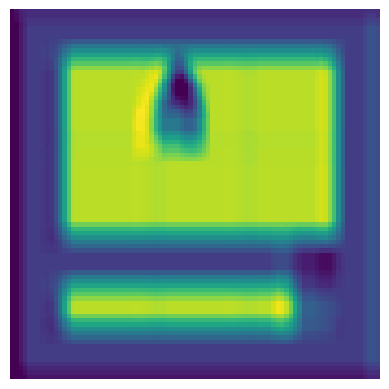

(8, 8, 1)
(8, 8, 1)
(8, 8, 1)


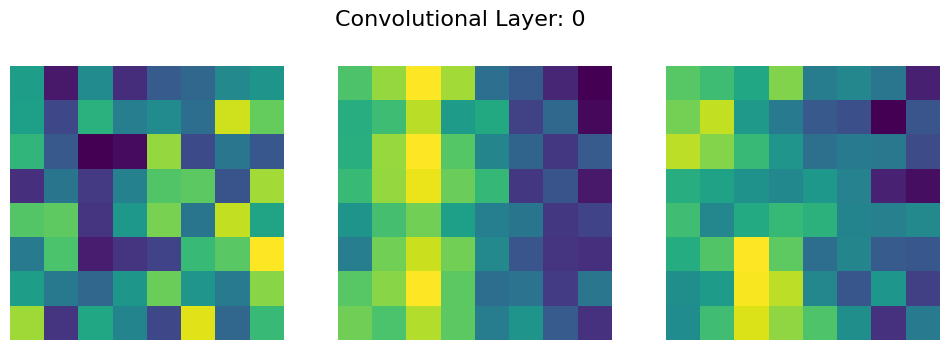

In [ ]:

def show_conv_weights(model):
    """
    Display the weights of convolutional layers in a PyTorch model.
    
    Args:
    - model (torch.nn.Module): PyTorch model.
    """
    # Iterate through all layers in the model
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            weights = module.weight.data.cpu().numpy()
            num_filters = weights.shape[0]
            num_channels = weights.shape[1]
            fig, axs = plt.subplots(num_filters, num_channels, figsize=(num_channels*4, num_filters*4))
            fig.suptitle(f"Convolutional Layer: {name}", fontsize=16)
            for i in range(num_filters):
                for j in range(num_channels):
                    print(weights[i, j, ..., None].shape)
                    axs[j].imshow(weights[i, j, ..., None])
                    axs[j].axis('off')
            plt.show()
for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
    state, action, reward, done, next_state = data

    state = preprocess(state)
    next_state = preprocess(next_state)
    img = net.preprocess(state)
    print(img.shape)

    plt.imshow(img[0].permute(1, 2, 0).detach().numpy())
    plt.axis('off')
    plt.show()
    show_conv_weights(net.preprocess)
    break

In [ ]:
torch.save(net.state_dict(), 'template.pt')

In [ ]:
model = ActionPredictor(input_dim=(3, 84, 84),
                      input_channels=3,
                      action_dim=action_n, 
                      cutoff=0.2,
                      template_var=[70, 26],)
model.load_state_dict(torch.load('template.pt'))

<All keys matched successfully>

torch.Size([16, 1, 85, 85])
tensor(0.) tensor(3.9975) tensor(False)
tensor(False)
tensor(0.) tensor(1.)


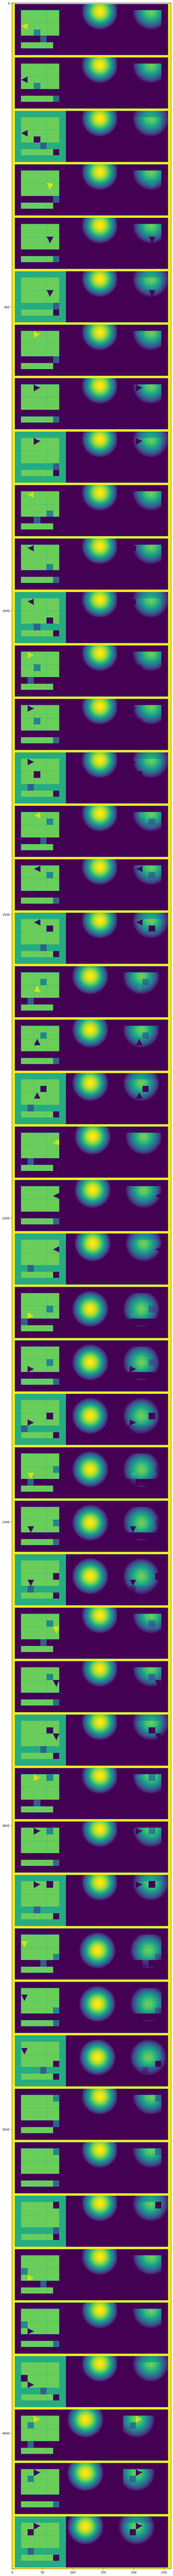

In [ ]:
def norm(tensor):
    tensor -= tensor.min()
    
    tensor /= tensor.max()
    return tensor


net.template.set_mixin_factor(0.8)

state, action, reward, done, next_state = next(train_loader.__iter__())

state = preprocess(state)

z = net.preprocess(state)
print(z.shape)
# z = z.view(-1, 42, 1, 9, 9).sum(1)
_, template = net.template.get_masked_output(z)
template = F.relu(template)
upscaled_template = F.interpolate(template, (84, 84), mode='bilinear')
print(upscaled_template.min(), upscaled_template.max(), upscaled_template.isnan().any())

avg_filter = upscaled_template.mean(dim=1)
print(avg_filter.isnan().any())
avg_filter = norm(avg_filter)
print(avg_filter.min(), avg_filter.max())
avg_filter = avg_filter.unsqueeze(dim=1).repeat(1, 3, 1, 1)

# print(template.min(),template.max())
# fig, ax = plt.subplots(figsize=(16, 120))
# template = template.view(-1, template.shape[-1])
# ax.imshow(template)
# plt.tight_layout()

states = state.detach().cpu()
states = states
# states = F.pad(states, (5, 5, 5, 5), mode='constant', value=0)
# avg_filter = F.pad(avg_filter, (5, 5, 5, 5), mode='constant', value=0)

img = torch.concat([states, avg_filter, states * avg_filter], dim=-1)
img = F.pad(img, (5, 5, 2, 2), mode='constant', value=1)
img = img.view(-1, img.shape[-1])

fig, ax = plt.subplots(figsize=(16, 120))
ax.imshow(img)
plt.tight_layout()



___0
___1
___2
___3
___4
___5
___6
___7
___8
___9
___10


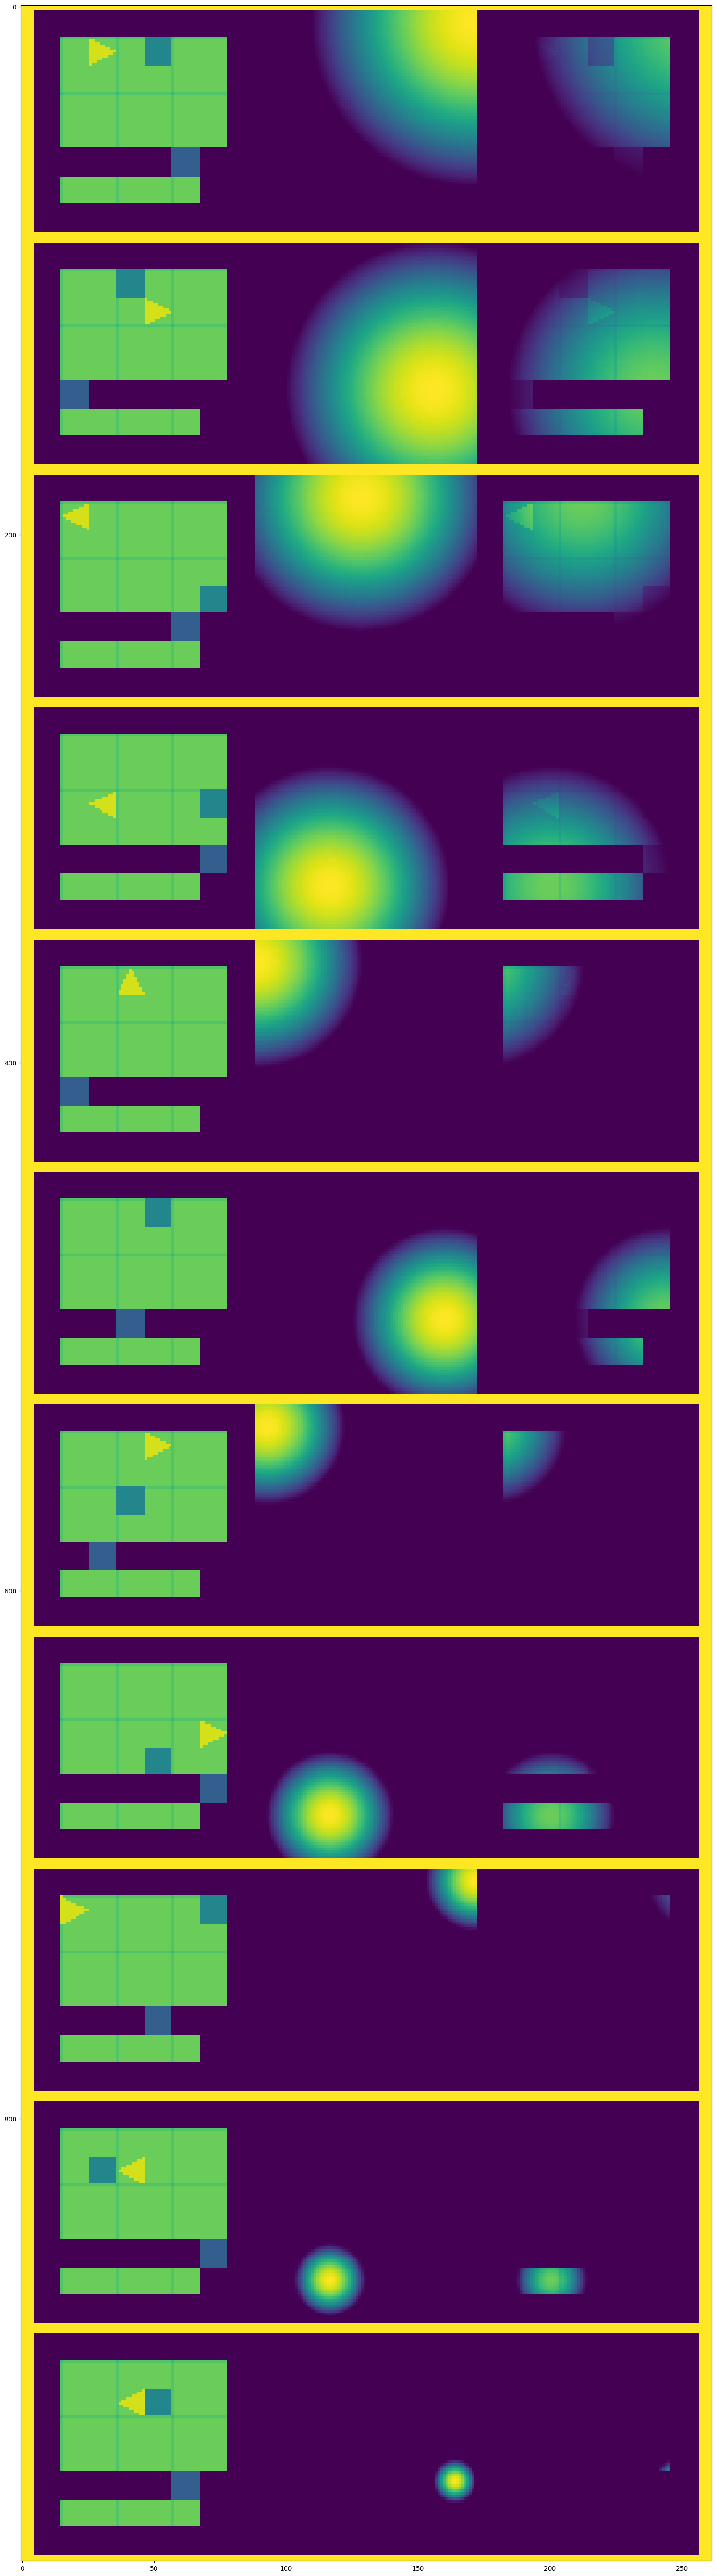

In [ ]:
def norm(tensor):
    tensor -= tensor.min()
    
    tensor /= tensor.max()
    return tensor


net = ActionPredictor(input_dim=(3, 84, 84),
                      input_channels=3,
                      action_dim=4, 
                      cutoff=0.2,
                      template_var=[70, 9],
                      )
s = []
for i in range(11):
    print('___' + str(i))
    net.template.set_mixin_factor(i * (1/10))

    state, action, reward, done, next_state = next(train_loader.__iter__())

    state = preprocess(state)

    z = net.preprocess(state)
    # z = z.view(-1, 42, 1, 9, 9).sum(1)
    _, template = net.template.get_masked_output(z)
    template = F.relu(template)
    upscaled_template = F.interpolate(template, (84, 84), mode='bilinear')

    avg_filter = upscaled_template.mean(dim=1)
    avg_filter = norm(avg_filter)
    avg_filter = avg_filter.unsqueeze(dim=1).repeat(1, 3, 1, 1)

    # print(template.min(),template.max())
    # fig, ax = plt.subplots(figsize=(16, 120))
    # template = template.view(-1, template.shape[-1])
    # ax.imshow(template)
    # plt.tight_layout()

    states = state.detach().cpu()
    states = states
    img = torch.concat([states, avg_filter, states * avg_filter], dim=-1)[0][0]
    img = F.pad(img, (5, 5, 2, 2), mode='constant', value=1)
    img = img.view(-1, img.shape[-1])
    s.append(img)

# states = F.pad(states, (5, 5, 5, 5), mode='constant', value=0)
# avg_filter = F.pad(avg_filter, (5, 5, 5, 5), mode='constant', value=0)

img = torch.concat(s, dim=0)
fig, ax = plt.subplots(figsize=(16, 120))
ax.imshow(img)
plt.tight_layout()



In [ ]:

class Template(nn.Module):
    def __init__(self, obs_shape, base_model_pth: str):
            self.base: ActionPredictor = torch.load(base_model_pth)

            self.preprocess = nn.Sequential(
                self.base.preprocess,
                nn.MaxPool2d(kernel_size=1, return_indices=True)
            )
            with torch.no_grad():
                self.out_shape = self.preprocess(torch.rand((1, *obs_shape)))[0].shape
            self.shape = obs_shape
            
    def construct_templates(self):
        w, h = self.shape.cpu().numpy()
        x, y = self.obs_shape.cpu().numpy()
        lin_w = w - np.absolute(np.linspace(1-w, w-1, 2*w-1))
        lin_h = h - np.absolute(np.linspace(1-h, h-1, 2*h-1))
        t = np.outer(lin_w, lin_h)  
        t = torch.Tensor(t).unfold(1, w, 1) \
                     .unfold(0, h, 1) \
                     .reshape(-1, w, h)
        templates = []
        for template in t.split(512):
            templates.append(cv2.resize(template.swapdims(0, -1).numpy(), (x, y), interpolation=cv2.INTER_CUBIC))
        t = np.concatenate(templates, axis=-1)
        t = torch.Tensor(t) > (w * (w - args.template_size))
        t = t.swapdims(-1, 0)
        t = F.relu(t.float() - args.alpha) + args.alpha
        return t.to(device)

    def get_mask_from_position(self, positions):
        pos = self.shape - positions - 1
        indices = pos[:, 1] * self.shape[0] + pos[:,0]
        m = self.template.templates[indices]
        return m[:, None]

    def get_mask(self, x):
        _, indices = self.preprocess(x)
        indices[0] = int(indices[0] / (self.out_shape[0]-1) * self.shape[0])
        indices[1] = int(indices[1] / (self.out_shape[1]-1) * self.shape[1])
        m = self.get_mask_from_position(indices)
        return m

    def forward(self, x):
        m = self.get_mask(x)
        return x * m
    